In [16]:
!nvidia-smi

Sun Nov 27 16:18:04 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P0    32W /  70W |    832MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
import torch
from torchvision.datasets import MNIST 
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn as nn
import numpy as np

### Function to transform and load the data with Torch

In [5]:
def get_dl(batchsize):

    # to transform the data as Tensors
    train_transforms = transforms.Compose([transforms.ToTensor()])
    
    # downloading train and test MNIST Data and transforming it to tensors
    train_data = MNIST(root="./train.",train=True,download=True,transform=train_transforms)
    test_data = MNIST(root="./test.",train=True,download=True,transform=train_transforms)
    
    # loading the data
    train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=False,drop_last=True)
    test_loader = DataLoader(test_data,batch_size=batchsize,shuffle=False,drop_last=True)
    
    # returning the train and test data 
    return train_loader,test_loader

### Generator network

In [6]:
class Generator(nn.Module):
    def __init__(self,batch_size,input_dim):
        super().__init__()
        self.batch_size = batch_size
        self.input_dim = input_dim
        self.fc1 = nn.Linear(input_dim,128)
        self.LRelu = nn.LeakyReLU()
        self.fc2 = nn.Linear(128,1*28*28)
        self.tanH = nn.Tanh()

    # function for forward propogation
    def forward(self,x):
        layer1 = self.LRelu(self.fc1(x))
        layer2 = self.tanH(self.fc2(layer1))
        out =layer2.view(self.batch_size,1,28,28)
        return out

### Discriminator network

In [7]:
class Discriminator(nn.Module):
    def __init__(self,batch_size):
        super().__init__()
        self.batch_size = batch_size
        self.fc1 = nn.Linear(1*28*28,128)
        self.LReLu = nn.LeakyReLU()
        self.fc2 = nn.Linear(128,1)
        self.SigmoidL = nn.Sigmoid()

    # function for forward propogation
    def forward(self,x):
        flat = x.view(self.batch_size,-1)
        layer1 = self.LReLu(self.fc1(flat))
        out = self.SigmoidL(self.fc2(layer1))
        return out.view(-1,1).squeeze(1)

### Function to train the model

In [14]:
def train_model(no_of_epochs,disc,gen,optimD,optimG,dataloaders,loss_fn,input_size,batch_size):
    """
    disc: Discriminator model
    gen: Generator model
    optimD: Optimizer for Discriminator
    optimG: Optimizer for Generator
    """
    
    # setting the device as cuda or cpu
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    reall = 1  # real label
    fakel = 0  # fake label
    #running each epoch
    for epoch in range(no_of_epochs):
        print('Epoch {}/{}'.format(epoch+1,no_of_epochs))
        running_loss_D = 0
        running_loss_G = 0
        for phase in ["train"]:
            #getting input and label from dataloader
            for inputs, _ in dataloaders[phase]:
                inputs = inputs.to(device)
                #converting labels into torch with proper size as per the batch size
                real_label = torch.full((batch_size,),reall,dtype=inputs.dtype,device=device)
                fake_label = torch.full((batch_size,),fakel,dtype=inputs.dtype,device=device)

                optimD.zero_grad()
                #output from discriminator
                output =disc(inputs)
                #Discriminator real loss
                # Compairing output label with real label which is loss
                D_real_loss = loss_fn(output,real_label)
                D_real_loss.backward()
                
                #random torch tensor as a noise data
                noise = torch.randn(batch_size,input_size,device=device)
                #passing noise throgh generator to get fake image
                fake = gen(noise)
                #passing fake image through discriminator with detaching(not passing gradient)
                output = disc(fake.detach())
                
                #Discriminator fake loss
                D_fake_loss = loss_fn(output,fake_label)
                #back propogation
                D_fake_loss.backward()

                # total loss for Discriminator
                Disc_loss = D_real_loss+D_fake_loss
                running_loss_D = running_loss_D+Disc_loss
                optimD.step()

                optimG.zero_grad()
                #passing fake image obtained from generator to discriminator
                output = disc(fake)
                #getting generator loss by giving fake image as input but giving real label
                Gen_loss = loss_fn(output,real_label)
                running_loss_G = running_loss_G + Gen_loss
                #backpropogation
                Gen_loss.backward()
                optimG.step()
        print("Discriminator Loss : {:.4f}".format(running_loss_D))
        print("Generator Loss : {:.4f}".format(running_loss_G))
        print("*********************************************************")

### Defining Model Parametrs

In [10]:
#fixing seed
torch.manual_seed(4)
batch_size = 128
no_of_epochs = 15
#input sixe for the latent variable
input_size = 100
#getting train and test data loader and putting them inside the dictionary
train_loader,test_loader = get_dl(batch_size)
dl = {}
dl['train'] = train_loader
dl['valid'] = test_loader
#discriminator model
disc  = Discriminator(batch_size)
#generator model
gen = Generator(batch_size,input_size)
#Optimizer for Discriminator
optimD  = torch.optim.Adam(disc.parameters(),lr=0.001,weight_decay=1e-05)
#Optimizer for Generator
optimG  = torch.optim.Adam(gen.parameters(),lr=0.001,weight_decay=1e-05)
#Binary cross entroy as loss function
loss_fn = torch.nn.BCELoss()
#moving models to the device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
disc.to(device)
gen.to(device)

Generator(
  (fc1): Linear(in_features=100, out_features=128, bias=True)
  (LRelu): LeakyReLU(negative_slope=0.01)
  (fc2): Linear(in_features=128, out_features=784, bias=True)
  (tanH): Tanh()
)

### Training the model

In [15]:
train_model(no_of_epochs,disc,gen,optimD,optimG,dl,loss_fn,input_size,batch_size)

Epoch 1/15
Discriminator Loss : 487.4575
Generator Loss : 643.2756
*********************************************************
Epoch 2/15
Discriminator Loss : 459.5562
Generator Loss : 710.8237
*********************************************************
Epoch 3/15
Discriminator Loss : 433.4444
Generator Loss : 783.2867
*********************************************************
Epoch 4/15
Discriminator Loss : 394.5756
Generator Loss : 917.0396
*********************************************************
Epoch 5/15
Discriminator Loss : 388.4313
Generator Loss : 879.9780
*********************************************************
Epoch 6/15
Discriminator Loss : 416.5942
Generator Loss : 920.9165
*********************************************************
Epoch 7/15
Discriminator Loss : 385.0018
Generator Loss : 981.7872
*********************************************************
Epoch 8/15
Discriminator Loss : 383.0998
Generator Loss : 983.3940
*********************************************************


### Function to plot the image

In [17]:
import matplotlib.pyplot as plt

def show_image(img):
  #converting imgae from tensor to numpy
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg,(1,2,0)))

### Generationg fake image from random noise

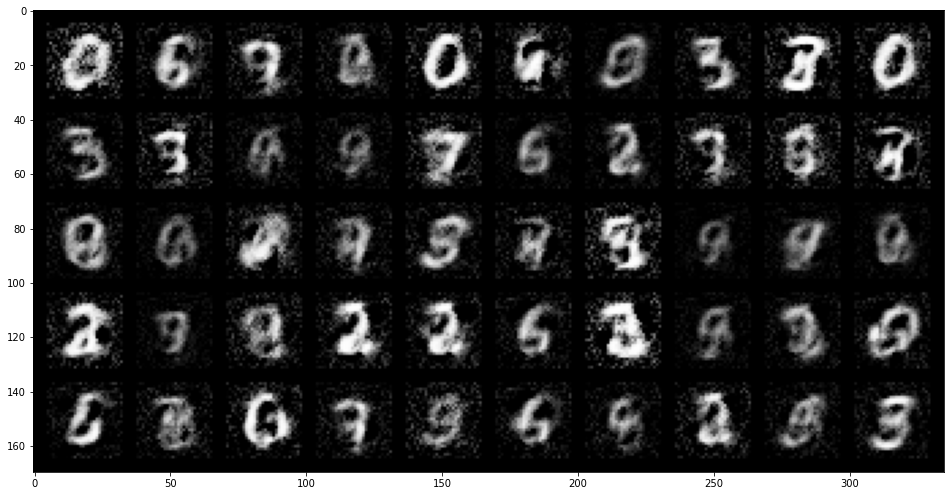

In [19]:
import torchvision
random_noise = torch.randn(128,input_size,device=device)
fake = gen(random_noise)
fake = fake.cpu()
#plotting the fake image
fig,ax = plt.subplots(figsize=(20,8.5))
show_image(torchvision.utils.make_grid(fake[0:50],10,5))
plt.show()

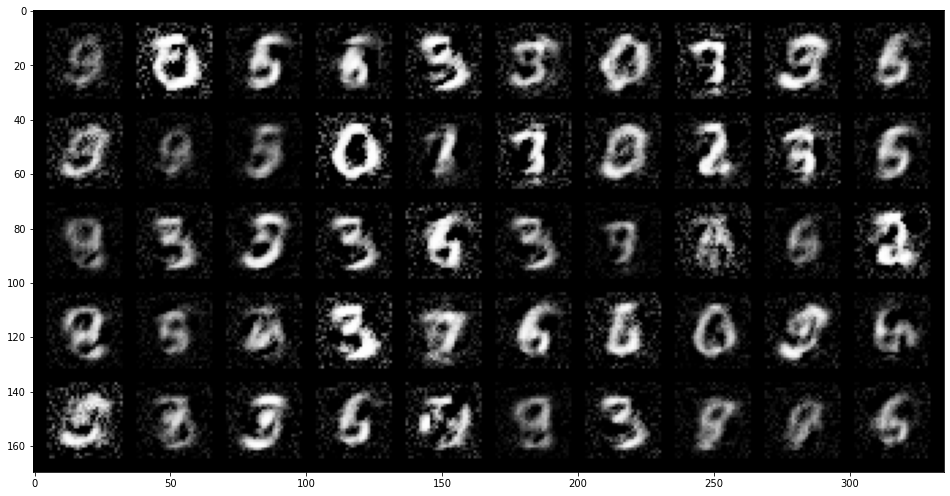

In [20]:
import torchvision
random_noise = torch.randn(128,input_size,device=device)
fake = gen(random_noise)
fake = fake.cpu()
#plotting the fake image
fig,ax = plt.subplots(figsize=(20,8.5))
show_image(torchvision.utils.make_grid(fake[0:50],10,5))
plt.show()